### Settings, imports, data

In [1]:
%matplotlib inline
from collections import OrderedDict
from IPython.display import display, Markdown
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import learn
from monitoring.data import get_production_data
from monitoring.visualization import display_level_overview

sns.set()
pd.options.display.float_format = '{:.2f}'.format

In [2]:
# Load data from local cache, fetch and store if not available.
data = get_production_data('2018-01-13')

Data loaded from cache (/home/xeffenb1/projects/robomission/.prodcache/robomission-2018-01-13/).


In [3]:
ts = data['task_sessions']
ts = ts[ts.time_spent > 0]
ts = ts.assign(date=ts.end.str[:10])

# Metrics

In [5]:
grouped_ts = ts.groupby('date')
metrics = pd.DataFrame(OrderedDict(
    active_students=grouped_ts.student.nunique(),
    solving_hours=grouped_ts.time_spent.sum() / 3600,
    solved_count=grouped_ts.solved.sum(),
    success_rate=grouped_ts.solved.mean(),
)).sort_index()

## Active Students

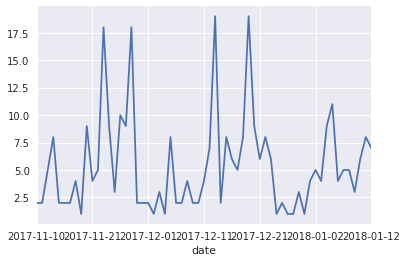

In [6]:
metrics.active_students.plot()

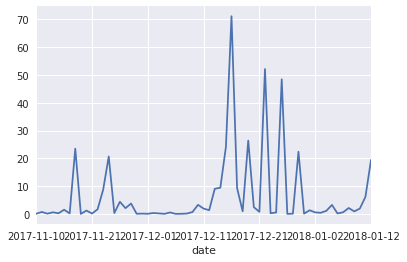

In [7]:
metrics.solving_hours.plot()

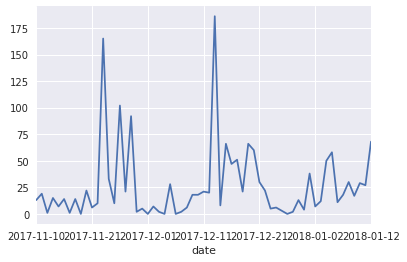

In [8]:
metrics.solved_count.plot()

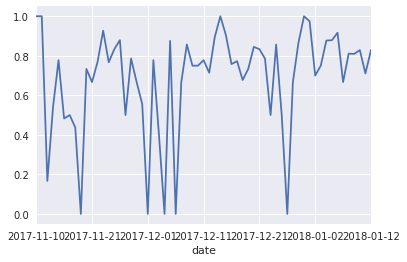

In [9]:
metrics.success_rate.plot()

# All task sessions

### Histogram of log-times

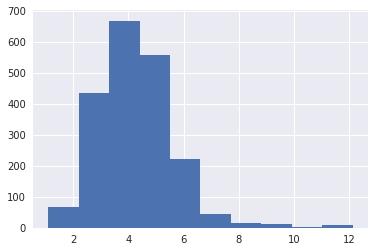

In [10]:
ts.time_spent.apply(np.log).hist()

# All tasks

In [11]:
grouped_ts = ts.groupby('task')
metrics = pd.DataFrame(OrderedDict(
    time=grouped_ts.time_spent.median(),
    success=grouped_ts.solved.mean(),
    n_attempts=grouped_ts.task.count(),
    n_solved=grouped_ts.solved.sum(),
))
metrics['n_unsolved'] = metrics.n_attempts - metrics.n_solved
tasks = data['tasks'].join(metrics).fillna(0)

### Solved and Unsolved Attempts

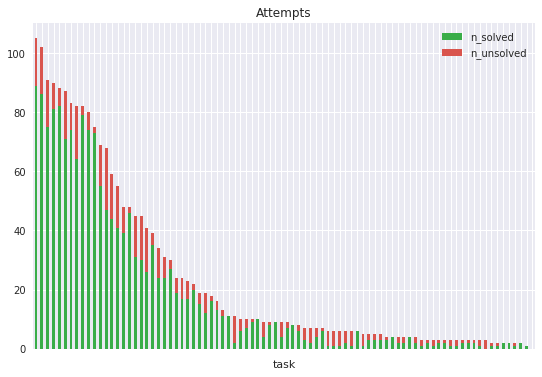

In [12]:
ordered_tasks = tasks.sort_values('n_attempts', ascending=False)
ax = ordered_tasks[['n_solved', 'n_unsolved']].plot.bar(
    title='Attempts',
    stacked=True,
    color=[sns.xkcd_rgb['medium green'], sns.xkcd_rgb['pale red']],
    figsize=(9,6))
ax.set_xticklabels([])
ax.set_xlabel('task');

### Success rate distribution

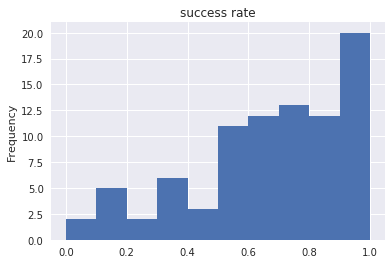

In [13]:
ax = tasks.success.plot.hist(title='success rate')

### Median time distribution

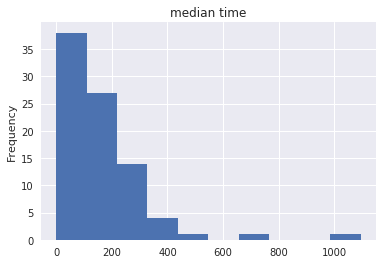

In [14]:
ax = tasks.time.plot.hist(title='median time')

### Median Time vs Success Rate

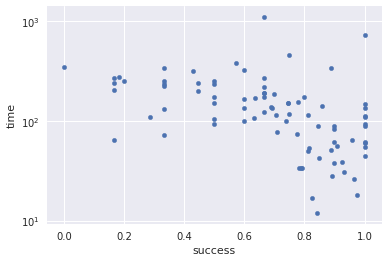

In [15]:
tasks.plot.scatter(x='success', y='time', logy=True)

# Levels Overview

In [16]:
grouped_tasks = tasks.groupby('level')
metrics = pd.DataFrame(OrderedDict(
    time=grouped_tasks.time.median(), # median of medians
    success=grouped_tasks.success.mean(),
    n_attempts=grouped_tasks.n_attempts.sum(),
    n_solved=grouped_tasks.n_solved.sum(),
))
levels = data['levels'].merge(metrics, left_on='name', right_index=True)
display_level_overview(levels)

,id,name,n_attempts,success,time
0,1,moves,787,84%,34s
1,2,world,456,83%,99s
2,3,repeat,359,82%,116s
3,4,while,159,86%,74s
4,5,loops,114,78%,107s
5,6,if,42,35%,252s
6,7,comparing,31,61%,233s
7,8,if-else,18,69%,152s
8,9,final-challenge,69,41%,229s


# Tasks in Levels

# moves

,id,name,n_attempts,success,time
8,51,one-step-forward,102,84%,12s
2,25,three-steps-forward,91,82%,17s
7,49,turning-right,83,89%,28s
5,44,turning-left,88,93%,30s
3,26,turning-right-and-left,82,78%,34s
10,67,plus,24,79%,34s
6,86,diamond-path,19,79%,34s
1,14,beware-of-asteroid,90,90%,38s
0,2,turning-left-and-right,105,85%,43s
9,66,surrounded-diamond,16,81%,50s


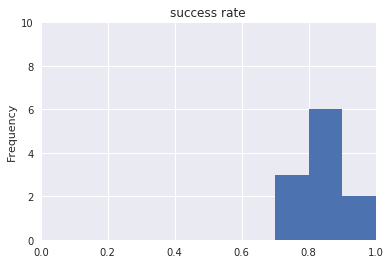

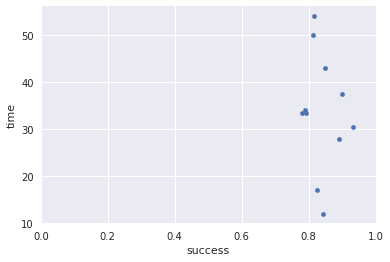

-----

# world

,id,name,n_attempts,success,time
1,10,shot,75,97%,18s
2,12,wormhole-demo,82,96%,26s
3,8,shooting,80,92%,39s
6,79,last-shot,23,74%,99s
5,23,dont-forget-shot,68,69%,136s
4,19,2diamonds-2meteorids,59,75%,150s
0,6,tunnel,69,80%,175s


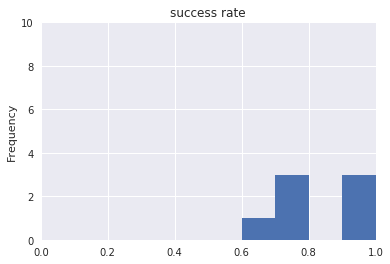

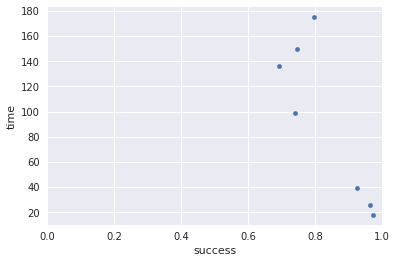

-----

# repeat

,id,name,n_attempts,success,time
9,71,big-left-turn,9,100%,45s
8,70,big-right-turn,11,100%,55s
0,11,ladder,48,96%,64s
3,1,diamonds-in-meteoroid-cloud,39,90%,84s
10,76,blocked-wormhole,10,90%,90s
1,13,n,48,81%,116s
7,84,triangle,8,75%,118s
4,46,find-the-path,45,67%,123s
5,57,stairs,45,69%,137s
2,21,steal-the-nose,55,75%,151s


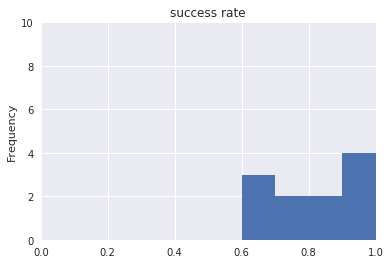

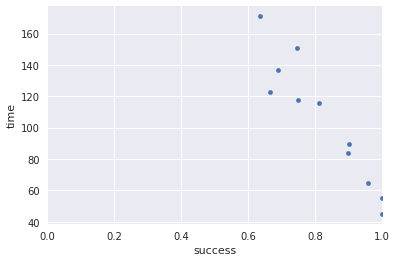

-----

# while

,id,name,n_attempts,success,time
4,53,direct-flight-ahead,22,91%,56s
5,73,stop-on-red,8,100%,61s
3,41,yellow-hint,30,90%,62s
0,3,zig-zag,31,77%,74s
1,17,yellow-is-not-red,24,71%,78s
6,69,diamond-in-house,10,100%,110s
2,38,direction-change,34,71%,114s


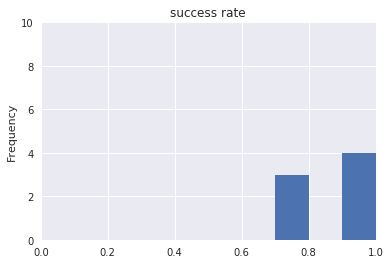

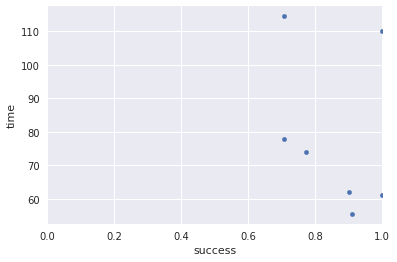

-----

# loops

,id,name,n_attempts,success,time
3,56,diamond-cross,18,89%,52s
8,68,stripes,6,100%,60s
1,50,double-bend,13,85%,89s
9,72,four-vs,4,100%,93s
4,55,color-slalom,10,60%,101s
0,37,big-slalom,19,63%,107s
7,63,rectangle,7,86%,140s
6,58,collect-diamonds,9,78%,155s
2,47,arrow,10,70%,188s
10,32,double-track,9,44%,241s


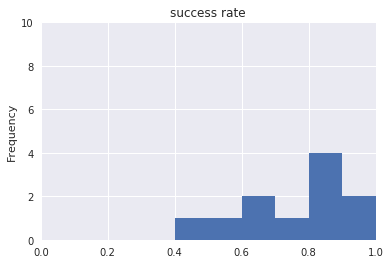

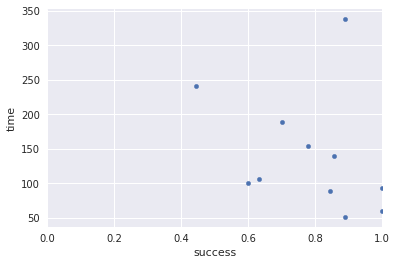

-----

# if

,id,name,n_attempts,success,time
3,60,red-shooting,7,29%,109s
4,34,follow-colors,5,60%,166s
0,5,diamonds-with-signals,9,44%,198s
6,81,belgian-flag,5,20%,252s
2,59,two-diamonds,6,17%,268s
1,27,on-yellow-to-left,7,43%,315s
5,78,yellow-squares,3,33%,342s


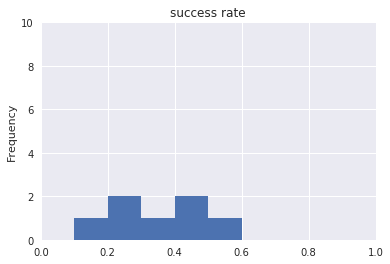

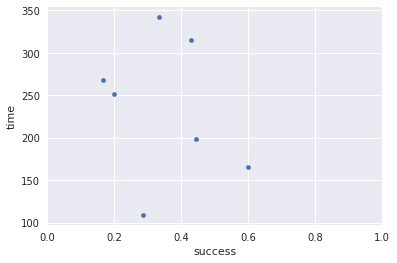

-----

# comparing

,id,name,n_attempts,success,time
2,85,chessboard,3,33%,73s
4,83,maneuvers-on-left,2,50%,104s
5,64,wave,1,100%,111s
0,9,diamond-lines,2,100%,134s
8,82,free-column,4,50%,233s
3,48,edge-to-edge,5,60%,325s
7,65,letter-h,3,0%,346s
1,28,slalom-position-testing,7,57%,383s
6,7,meteoroids-and-wormholes,4,100%,722s


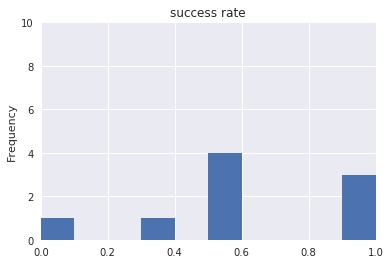

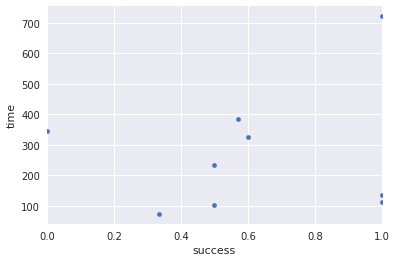

-----

# if-else

,id,name,n_attempts,success,time
3,29,color-navigation,2,100%,90s
5,24,narrow-passage,4,50%,93s
6,80,letter-e,2,100%,148s
1,75,bouncing-from-edge,2,50%,152s
0,43,colorful-flowers,3,67%,173s
4,16,diamonds-on-yellow,2,50%,174s
2,22,triple-steps,3,67%,219s


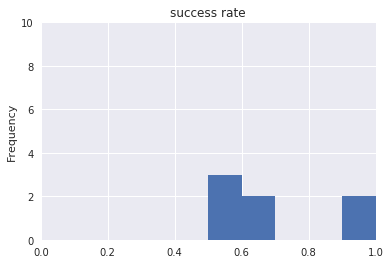

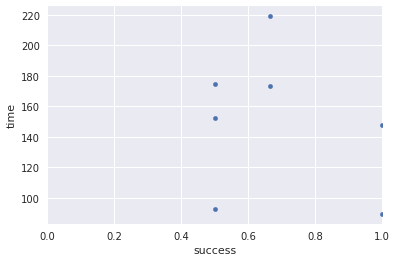

-----

# final-challenge

,id,name,n_attempts,success,time
13,74,turning-in-square,0,0%,0s
7,40,plan-your-shooting,6,17%,65s
11,45,diagonal-lines,3,33%,131s
3,20,five-diamonds,5,60%,134s
4,30,edge-wormholes,3,67%,191s
10,39,meteoroids-on-left,3,67%,191s
12,33,diamond-ring,6,17%,203s
9,62,two-bit-instructions,3,33%,222s
5,35,six-diamonds,3,33%,236s
15,61,mirror,6,17%,240s


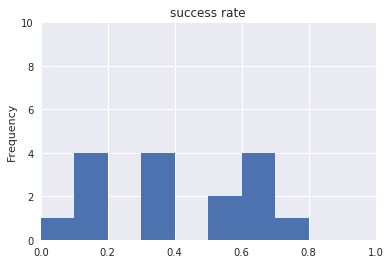

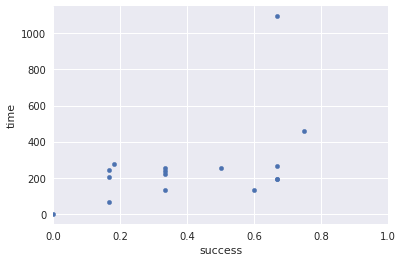

-----

In [17]:
def display_plot(ax):
    display(ax)
    plt.show()  # forcing to display here

def display_success_rate_hist(tasks):
    ax = tasks.success.plot.hist(
        bins=np.linspace(0, 1, 11),
        title='success rate')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 10)
    display_plot(ax)
    
def display_time_vs_success(tasks):
    ax = tasks.plot.scatter(x='success', y='time')
    ax.set_xlim(0, 1)
    display_plot(ax)
    
def analyze_level(name):
    ts = tasks[tasks.level == name]
    ts = ts[['name', 'n_attempts', 'success', 'time']]
    display(Markdown('# {name}'.format(name=name)))
    display_level_overview(ts, order_by='time')
    display_success_rate_hist(ts)
    display_time_vs_success(ts)
    display(Markdown('-----'))

for name in levels.name:
    analyze_level(name)